### Import library

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns
import PIL

### Load dataset

In [2]:
path_normal = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
path_covid = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
path_lung_opacity = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
path_viral_pneumonia = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))
len_lung_opacity =  len(os.listdir(path_lung_opacity))
len_viral_pneumonia = len(os.listdir(path_viral_pneumonia))

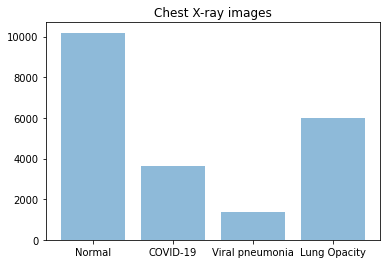

In [3]:
objects = ('Normal', 'COVID-19', 'Viral pneumonia', 'Lung Opacity')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid, len_viral_pneumonia, len_lung_opacity]

plt.bar(y_pos,performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Chest X-ray images')

plt.show()

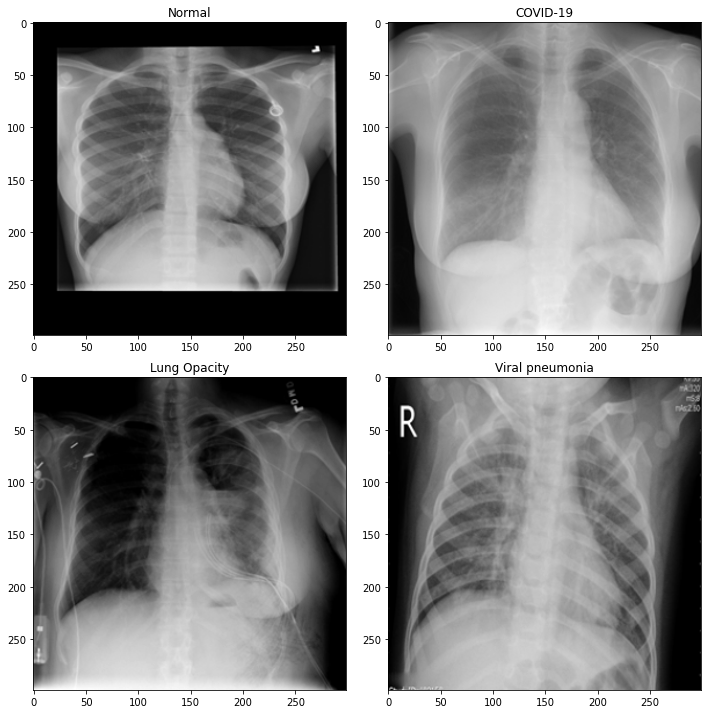

In [4]:
labels = ['Normal', 'COVID-19','Lung Opacity', 'Viral pneumonia']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1994.png"
img3 = path_lung_opacity+"/Lung_Opacity-1.png"
img4 = path_viral_pneumonia + "/Viral Pneumonia-1.png"

imgs = [img1, img2, img3, img4]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

### Preprocess image

In [5]:
from PIL import Image, ImageOps
def resize_image(imgpath):
    img = Image.open(imgpath)
#     img = ImageOps.autocontrast(img, cutoff=0.5)
    img = np.array(ImageOps.colorize(img.resize((150,150), PIL.Image.Resampling.LANCZOS), black="black", white="white"))
    return img

In [6]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
for i in os.listdir(path_lung_opacity):
    try:
        imgpath = path_lung_opacity+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(2)
    except:
        None
for i in os.listdir(path_viral_pneumonia):
    try:
        imgpath = path_viral_pneumonia+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(3)
    except:
        None
x_ = np.array(x_)

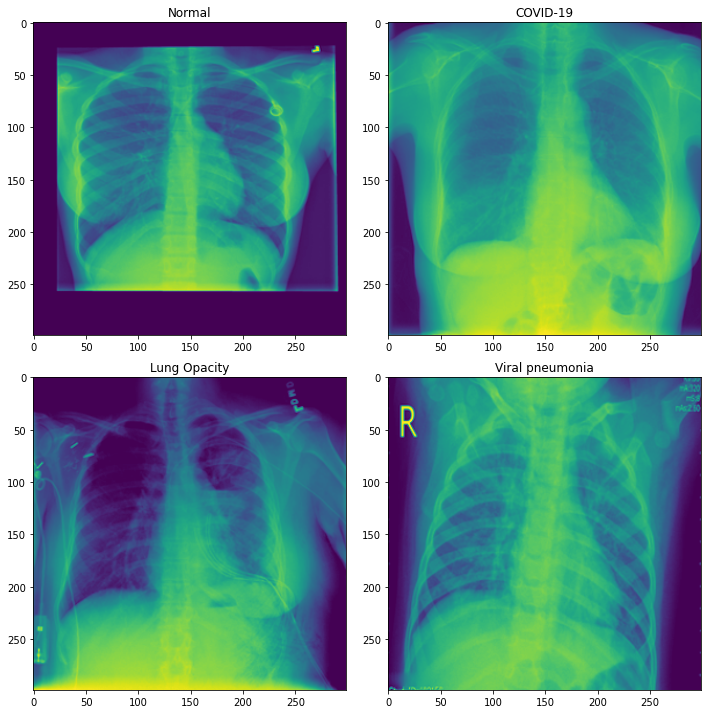

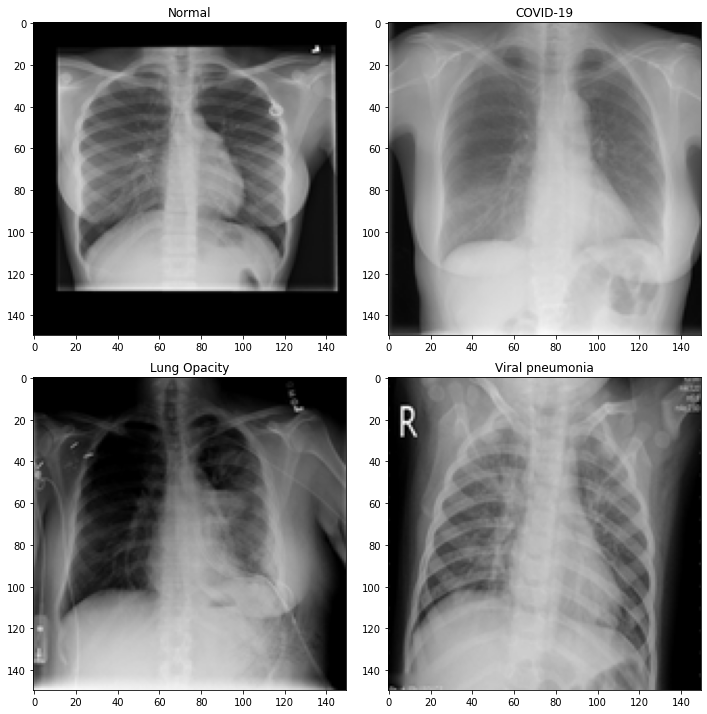

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
plt.tight_layout()
for i in range(0,4):
    ax[i].imshow(plt.imread(imgs[i]))
    ax[i].set_title(labels[i])
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
plt.tight_layout()
for i in range(0,4):
    ax[i].imshow(resize_image(imgs[i]))
    ax[i].set_title(labels[i])

In [8]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y,num_classes = 4)

classNames = ["normal","COVID_19", "lung_opacity","viral_pneumonia"]
print(classNames)

['normal', 'COVID_19', 'lung_opacity', 'viral_pneumonia']


> ### Split dataset to train, validation, test

In [9]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.1,random_state = 40)

In [10]:
print(x_train.shape)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
print(y_train.shape)

(15138, 150, 150, 3)
(15138, 4)


In [ ]:
## Adding 1 dimension as batch.
# Y_train=tf.expand_dims(y_train, axis=-1)
# Y_test=tf.expand_dims(y_test, axis=-1)
# Y_val =tf.expand_dims(y_val, axis=-1)

# Y_train.shape

In [11]:
unique, counts = np.unique(np.argmax(y_train,axis=1), return_counts=True)
uniqueVal, countsVal = np.unique(np.argmax(y_val,axis=1), return_counts=True)
print(dict(zip(unique, counts)))

{0: 7346, 1: 2611, 2: 4316, 3: 865}


In [12]:
dict(zip(uniqueVal, countsVal))

{0: 807, 1: 293, 2: 475, 3: 107}

## Model InceptionV3 Transfer learning

In [13]:
# download pre-trained model imagenet
baseModel = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (150,150,3),
    classifier_activation = 'sigmoid'
)

2022-10-03 12:47:07.198976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:47:07.206758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:47:07.207433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 12:47:07.209088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Define model output

In [14]:
for layer in baseModel.layers:           
  layer.trainable = False

'''
Definition of the Keras model outputs
'''

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = BatchNormalization()(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)

headModel = Dense(4, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
optimizers = Adam(lr=0.0001,decay=5e-6)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
model.summary()
tf.keras.utils.plot_model(model,to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, cooldown=0, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',classes = np.unique(np.argmax(y_train, axis=1)), y = np.argmax(y_train, axis=1))
cw = dict(zip( np.unique(np.argmax(y_train, axis=1)), weights))
print(cw)

{0: 0.5151783283419548, 1: 1.4494446572194561, 2: 0.8768535681186284, 3: 4.3751445086705205}


In [17]:
hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val,y_val), class_weight=cw, callbacks=callbacks_list)

2022-10-03 12:48:10.509914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1021815000 exceeds 10% of free system memory.
2022-10-03 12:48:11.666121: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1021815000 exceeds 10% of free system memory.
2022-10-03 12:48:12.534736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-03 12:48:17.642073: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


474/474 [==============================] - 24s 37ms/step - loss: 0.8399 - accuracy: 0.6235 - val_loss: 0.7880 - val_accuracy: 0.7015
Epoch 2/50
474/474 [==============================] - 17s 36ms/step - loss: 0.6318 - accuracy: 0.7157 - val_loss: 0.7512 - val_accuracy: 0.7271
Epoch 3/50
474/474 [==============================] - 16s 33ms/step - loss: 0.5685 - accuracy: 0.7412 - val_loss: 0.6796 - val_accuracy: 0.7449
Epoch 4/50
474/474 [==============================] - 16s 33ms/step - loss: 0.5259 - accuracy: 0.7601 - val_loss: 0.6516 - val_accuracy: 0.7622
Epoch 5/50
474/474 [==============================] - 16s 33ms/step - loss: 0.4933 - accuracy: 0.7748 - val_loss: 0.6202 - val_accuracy: 0.7765
Epoch 6/50
474/474 [==============================] - 16s 34ms/step - loss: 0.4622 - accuracy: 0.7903 - val_loss: 0.6309 - val_accuracy: 0.7616
Epoch 7/50
474/474 [==============================] - 16s 33ms/step - loss: 0.4386 - accuracy: 0.8007 - val_loss: 0.5953 - val_accuracy: 0.7782
Epo

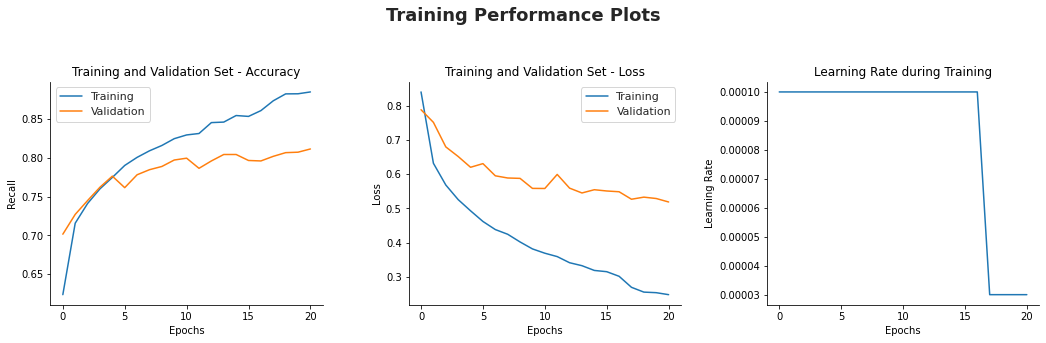

In [18]:
import seaborn as sns

#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist.history)

ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=18, weight = 'bold');
fig.tight_layout(pad=2.0)      
plt.show()

## Test and Evaluate model

In [19]:
test_accu = model.evaluate(x_test, y_test)
print('The testing accuracy is :',test_accu[1]*100, '%')

132/132 [==============================] - 4s 33ms/step - loss: 0.4942 - accuracy: 0.8262
The testing accuracy is : 82.61593580245972 %


In [20]:
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=-1)
predictions

array([0, 2, 0, ..., 2, 0, 2])

### Confusion matrix & Classification report


<AxesSubplot:>

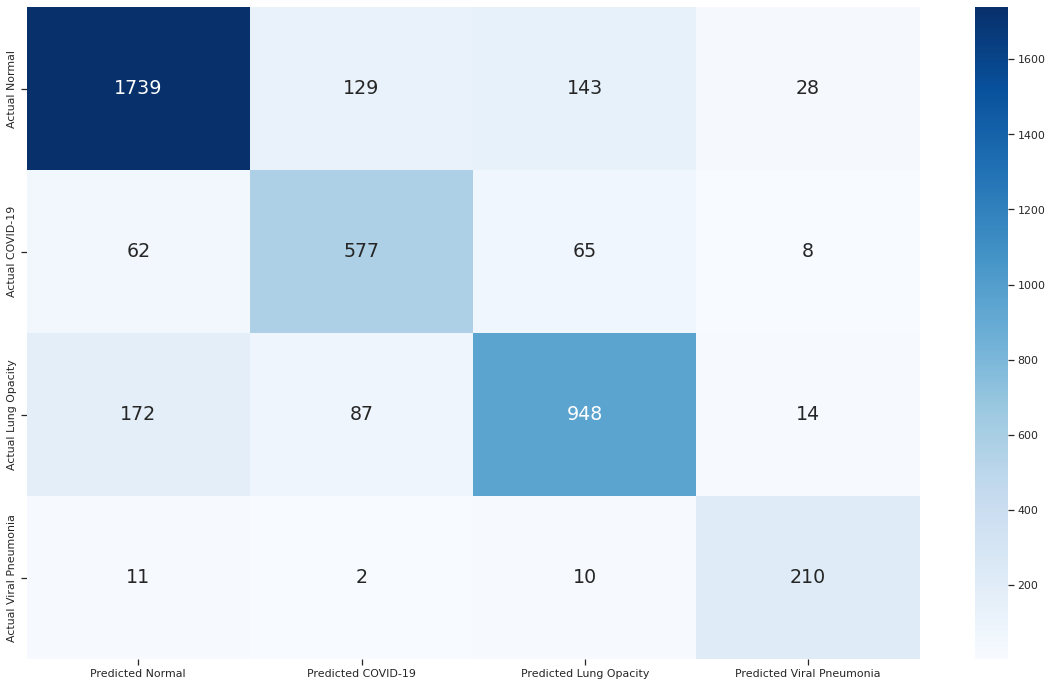

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(np.argmax(y_test, axis=1), preds.argmax(axis=1), labels=[0,1,2,3]),index=["Actual Normal", "Actual COVID-19", "Actual Lung Opacity", "Actual Viral Pneumonia"],
columns=["Predicted Normal", "Predicted COVID-19", "Predicted Lung Opacity", "Predicted Viral Pneumonia"])
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams.update({'font.size': 19})
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",ax=ax)

In [22]:
print(classification_report(y_true=np.argmax(y_test, axis=1),y_pred=preds.argmax(axis=1),target_names =["Normal", "COVID-19", "Lung Opacity", "Viral Pneumonia"]))

                 precision    recall  f1-score   support

         Normal       0.88      0.85      0.86      2039
       COVID-19       0.73      0.81      0.77       712
   Lung Opacity       0.81      0.78      0.79      1221
Viral Pneumonia       0.81      0.90      0.85       233

       accuracy                           0.83      4205
      macro avg       0.81      0.84      0.82      4205
   weighted avg       0.83      0.83      0.83      4205



# Show Result Prediction

if predicted label is equal to real label we can see the text and bar in blue.
if predicted label is not equal to real label we can see the text and bar in red.

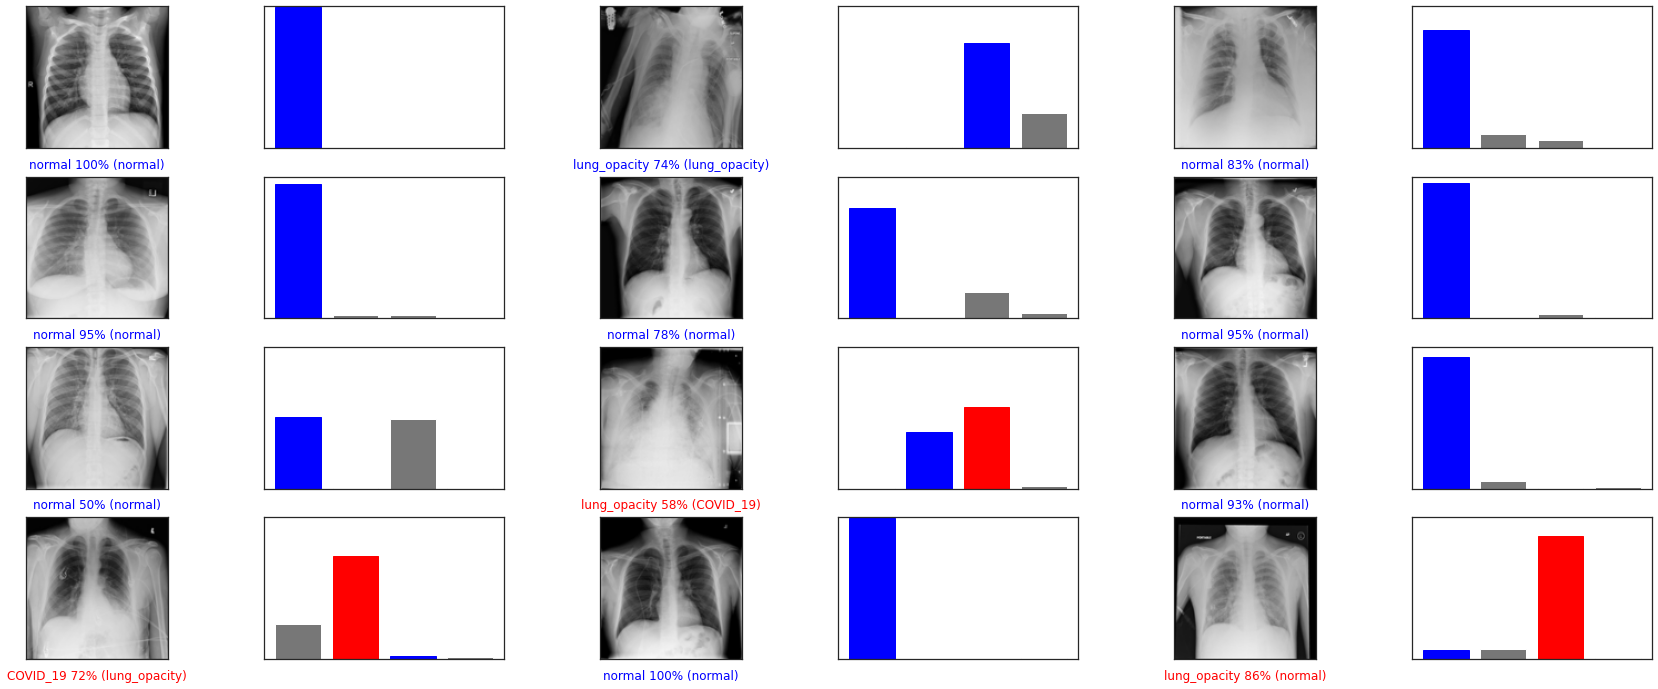

In [23]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = cv2.resize(img,(128,128))
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label= np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)
    
def showResultPrediction(predictions):
    num_rows = 4
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(5*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, y_test, x_test)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, y_test)
    plt.show()

showResultPrediction(preds)

# References
https://www.kaggle.com/code/newsknowledge/covit19-detection-using-inceptionv3